# Geometría y Cinemática de las Patas de un Robot

## Geometría de las Patas del Robot

Consideremos un robot con una pata que tiene dos articulaciones:
1. **Cadera** (`theta1`): Une el torso del robot a la parte superior de la pierna.
2. **Rodilla** (`theta2`): Une la parte superior de la pierna a la parte inferior.

Las longitudes de los eslabones son:
- \( l1 \): Longitud desde la cadera hasta la rodilla.
- \( l2 \): Longitud desde la rodilla hasta el pie.

## Cinemática Directa

La matriz de transformación homogénea para una rotación y una traslación en 2D se puede representar como:



\begin{equation}
\left[
\begin{matrix}
cos(\theta) & -\sin(\theta) & d_x \\
sin(\theta) & \cos(\theta) & d_y \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}

Para nuestro robot, necesitamos dos matrices de transformación:
1. Desde la cadera hasta la rodilla.
2. Desde la rodilla hasta el pie.

## Matrices de Transformación

Para la cadera a la rodilla:

\begin{equation}
\left[
\begin{matrix}
cos(\theta_1) & -\sin(\theta_1) & l1 \cos(\theta_1) \\
sin(\theta_1) & \cos(\theta_1) & l1 \sin(\theta_1) \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}

Para la rodilla al pie:

\begin{equation}
\left[
\begin{matrix}
cos(\theta_2) & -\sin(\theta_2) & l2 \cos(\theta_2) \\
sin(\theta_2) & \cos(\theta_2) & l2 \sin(\theta_2) \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}


La posición final del pie se obtiene multiplicando estas matrices.

\begin{equation}
\left[
\begin{matrix}
\cos{\left(\theta_{1} + \theta_{2} \right)} & - \sin{\left(\theta_{1} + \theta_{2} \right)} & l_{1} \cos{\left(\theta_{1} \right)} + l_{2} \cos{\left(\theta_{1} + \theta_{2} \right)} \\
\sin{\left(\theta_{1} + \theta_{2} \right)} & \cos{\left(\theta_{1} + \theta_{2} \right)} & l_{1} \sin{\left(\theta_{1} \right)} + l_{2} \sin{\left(\theta_{1} + \theta_{2} \right)} \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}



### IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle


calibrations = {}

DERECHA_SUPERIOR = 0
DERECHA_INFERIOR = 1
IZQUIERDA_SUPERIOR = 2
IZQUIERDA_INFERIOR = 3

### PASOS DEL ROBOT PARA MOVER UNA PIERNA

IndexError: index 5 is out of bounds for axis 0 with size 4

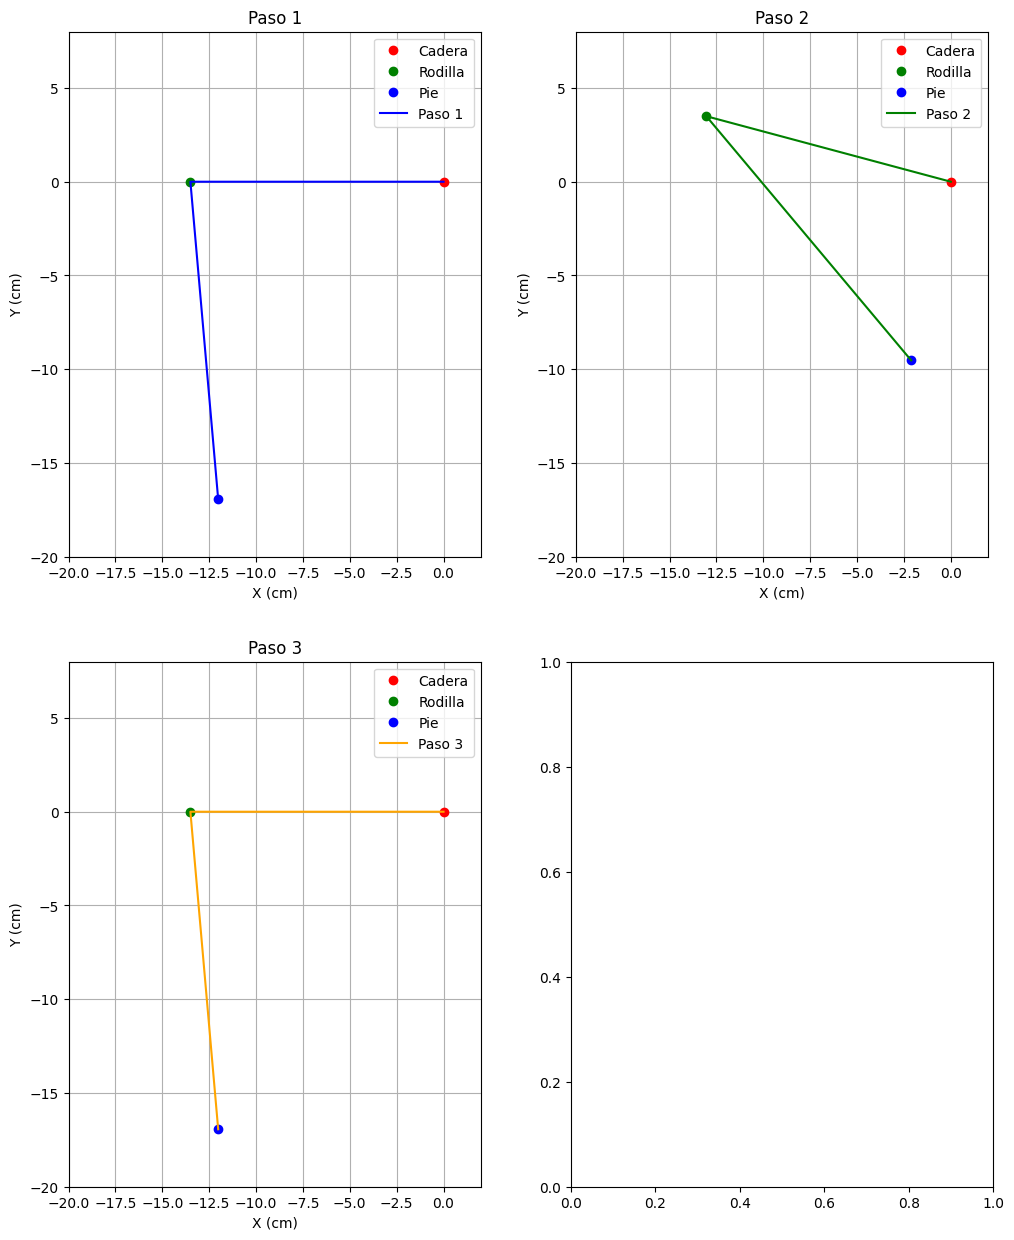

In [5]:

# Longitudes de los eslabones
l1 = 13.5  # longitud de la cadera a la rodilla (cm)
l2 = 17  # longitud de la rodilla al pie (cm)

# Ángulos de las articulaciones (en grados) para los cinco pasos
thetas =  [
    (180, 95),  # Paso 1
    (165, 145),   # Paso 2
    (180, 95),   # Paso 5 (volver al paso inicial)
]

# Colores para los diferentes pasos
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Crear la figura y los ejes para los cinco subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 15))
axs = axs.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

# Iterar sobre cada paso y visualizar la posición del pie en cada paso
for i, (theta1, theta2) in enumerate(thetas, start=1):
    # Calcular las coordenadas del pie (posición final)
    x_foot = l1 * np.cos(np.radians(theta1)) + l2 * np.cos(np.radians(theta1 + theta2))
    y_foot = l1 * np.sin(np.radians(theta1)) + l2 * np.sin(np.radians(theta1 + theta2))
    
    # Visualizar la posición del pie en el subgráfico correspondiente
    ax = axs[i-1]
    ax.plot(0, 0, 'ro', label='Cadera')
    ax.plot(l1 * np.cos(np.radians(theta1)), l1 * np.sin(np.radians(theta1)), 'go', label='Rodilla')
    ax.plot(x_foot, y_foot, 'bo', label='Pie')
    ax.plot([0, l1 * np.cos(np.radians(theta1)), x_foot], [0, l1 * np.sin(np.radians(theta1)), y_foot], 
            color=colors[i-1], label=f'Paso {i}')

    # Configurar el subgráfico
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_title(f'Paso {i}')
    ax.grid(True)
    ax.set_xlim(-20, 2)
    ax.set_ylim(-20, 8)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()

# Añadir un espacio vacío para el último subgráfico que no se usa
axs[5].axis('off')

plt.tight_layout()
plt.show()


### FUNCIONES DE CALIBRACIÓN, MAPEADO DE ANGULOS 

In [6]:
# Función de calibración
def calibrate_servo(servo_name, joint_angle_ref, servo_angle_ref, calibrations):
    calibrations[servo_name] = {
        'joint_angle_ref': joint_angle_ref,
        'servo_angle_ref': servo_angle_ref,
    }
    return calibrations

# Función de mapeo de ángulos
def map_angle_to_servo(servo_name, joint_angle, calibrations):
    calib = calibrations[servo_name]
    
    if IZQUIERDA_SUPERIOR == servo_name:
        servo_angle = (calib['joint_angle_ref'] - joint_angle) + calib['servo_angle_ref']
    elif IZQUIERDA_INFERIOR == servo_name:
        servo_angle = (joint_angle - calib['joint_angle_ref']) + calib['servo_angle_ref']
    elif DERECHA_SUPERIOR == servo_name:
        servo_angle = (joint_angle - calib['joint_angle_ref']) + calib['servo_angle_ref']
    elif DERECHA_INFERIOR == servo_name:
        servo_angle = (calib['joint_angle_ref'] - joint_angle) + calib['servo_angle_ref']
    else:
        return None
    
    if servo_angle < 0 or servo_angle > 180:
        return None
    return servo_angle

# Función de mapeo de servo a ángulo
def map_servo_to_angle(servo_name, servo_angle, calibrations):
    if servo_angle < 0 or servo_angle > 180:
        return None
    
    calib = calibrations[servo_name]

    if IZQUIERDA_SUPERIOR == servo_name:
        joint_angle = calib['joint_angle_ref'] + (calib['servo_angle_ref'] - servo_angle)
    elif IZQUIERDA_INFERIOR == servo_name:
        joint_angle = (servo_angle - calib['servo_angle_ref']) + calib['joint_angle_ref']
    elif DERECHA_SUPERIOR == servo_name:
        joint_angle = (servo_angle - calib['servo_angle_ref']) + calib['joint_angle_ref']
    elif DERECHA_INFERIOR == servo_name:
        joint_angle = calib['joint_angle_ref'] + (calib['servo_angle_ref'] - servo_angle)
    else:
        return None

    if joint_angle < 0:
        return 360 + joint_angle
    
    return joint_angle

# Función de prueba para calibrate_servo
def test_calibrate_servo():
    calibrations = {}
    calibrate_servo(IZQUIERDA_SUPERIOR, 185, 150, calibrations)
    calibrate_servo(IZQUIERDA_INFERIOR, 100, 135, calibrations)
    calibrate_servo(DERECHA_SUPERIOR, 185, 30, calibrations)
    calibrate_servo(DERECHA_INFERIOR, 100, 45, calibrations)

    assert calibrations[IZQUIERDA_SUPERIOR] == {'joint_angle_ref': 185, 'servo_angle_ref': 150}
    assert calibrations[IZQUIERDA_INFERIOR] == {'joint_angle_ref': 100, 'servo_angle_ref': 135}
    assert calibrations[DERECHA_SUPERIOR] == {'joint_angle_ref': 185, 'servo_angle_ref': 30}
    assert calibrations[DERECHA_INFERIOR] == {'joint_angle_ref': 100, 'servo_angle_ref': 45}
    print("test_calibrate_servo passed")

# Función de prueba para map_angle_to_servo
def test_map_angle_to_servo():
    calibrations = {}
    calibrate_servo(IZQUIERDA_SUPERIOR, 185, 150, calibrations)
    calibrate_servo(IZQUIERDA_INFERIOR, 100, 135, calibrations)
    calibrate_servo(DERECHA_SUPERIOR, 185, 30, calibrations)
    calibrate_servo(DERECHA_INFERIOR, 100, 45, calibrations)

    # Testing map_angle_to_servo
    assert map_angle_to_servo(IZQUIERDA_SUPERIOR, 175, calibrations) == 160
    assert map_angle_to_servo(IZQUIERDA_INFERIOR, 100, calibrations) == 135
    assert map_angle_to_servo(DERECHA_SUPERIOR, 175, calibrations) == 20
    assert map_angle_to_servo(DERECHA_INFERIOR, 100, calibrations) == 45
    assert map_angle_to_servo(DERECHA_SUPERIOR, 120, calibrations) == None

    print("test_map_angle_to_servo passed")

# Función de prueba para map_servo_to_angle
def test_map_servo_to_angle():
    calibrations = {}
    calibrate_servo(IZQUIERDA_SUPERIOR, 185, 150, calibrations)
    calibrate_servo(IZQUIERDA_INFERIOR, 100, 135, calibrations)
    calibrate_servo(DERECHA_SUPERIOR, 185, 30, calibrations)
    calibrate_servo(DERECHA_INFERIOR, 100, 45, calibrations)

    assert map_servo_to_angle(IZQUIERDA_SUPERIOR, 160, calibrations) == 175
    assert map_servo_to_angle(IZQUIERDA_INFERIOR, 135, calibrations) == 100
    assert map_servo_to_angle(DERECHA_SUPERIOR, 20, calibrations) == 175
    assert map_servo_to_angle(DERECHA_INFERIOR, 45, calibrations) == 100
    assert map_servo_to_angle(DERECHA_INFERIOR, 200, calibrations) == None

    print("test_map_servo_to_angle passed")


In [7]:

# Ejecución de las pruebas
test_calibrate_servo()
test_map_angle_to_servo()
test_map_servo_to_angle()



test_calibrate_servo passed
test_map_angle_to_servo passed
test_map_servo_to_angle passed


### CONVERSIÓN DE ANGULOS EN REPRESENTACIÓN GEOMÉTRICA A ANGULOS EN SERVOS

In [14]:

# Calibración proporcionada por el usuario
calibrations = calibrate_servo(IZQUIERDA_SUPERIOR, 180, 145, calibrations)  # Calibración del servo 1: (185 en esquema) => 150 grados en el servo
calibrations = calibrate_servo(IZQUIERDA_INFERIOR, 95, 130, calibrations)   # Calibración del servo 2: (100 en esquema) => 130 grados en el servo
calibrations = calibrate_servo(DERECHA_SUPERIOR, 180, 45, calibrations)  # Calibración del servo 1: (185 en esquema) => 150 grados en el servo
calibrations = calibrate_servo(DERECHA_INFERIOR, 95, 50, calibrations)   # Calibración del servo 2: (100 en esquema) => 45 grados en el servo


# Los ángulos de las articulaciones para los cinco pasos
joint_angles = [
    (180, 95),  # Paso 1
    (145, 95),   # Paso 2
    (145, 145),   # Paso 3
    (180, 145),  # Paso 4
    (180, 95),   # Paso 5 (volver al paso inicial)
]

servo_angles_izquierda = []
for joint1, joint2 in joint_angles:
    servo1 = map_angle_to_servo(IZQUIERDA_SUPERIOR, joint1, calibrations)
    servo2 = map_angle_to_servo(IZQUIERDA_INFERIOR, joint2, calibrations)
    
    if (servo1 == None or servo2 == None):
        continue
    servo_angles_izquierda.append((servo1, servo2))


servo_angles_derecha =[]
for joint1, joint2 in joint_angles:
    servo1 = map_angle_to_servo(DERECHA_SUPERIOR, joint1, calibrations)
    servo2 = map_angle_to_servo(DERECHA_INFERIOR, joint2, calibrations)
    if (servo1 == None or servo2 == None):
        continue
    servo_angles_derecha.append((servo1, servo2))

for i, (servo1, servo2) in enumerate(servo_angles_derecha, start=1):
    print(f'Paso {i}: Servo 1: {servo1:.2f} grados, Servo 2: {servo2:.2f} grados')

print("------------------------------------------------------------------")

for i, (servo1, servo2) in enumerate(servo_angles_izquierda, start=1):
    print(f'Paso {i}: Servo 1: {servo1:.2f} grados, Servo 2: {servo2:.2f} grados')

Paso 1: Servo 1: 45.00 grados, Servo 2: 50.00 grados
Paso 2: Servo 1: 10.00 grados, Servo 2: 50.00 grados
Paso 3: Servo 1: 10.00 grados, Servo 2: 0.00 grados
Paso 4: Servo 1: 45.00 grados, Servo 2: 0.00 grados
Paso 5: Servo 1: 45.00 grados, Servo 2: 50.00 grados
------------------------------------------------------------------
Paso 1: Servo 1: 145.00 grados, Servo 2: 130.00 grados
Paso 2: Servo 1: 180.00 grados, Servo 2: 130.00 grados
Paso 3: Servo 1: 180.00 grados, Servo 2: 180.00 grados
Paso 4: Servo 1: 145.00 grados, Servo 2: 180.00 grados
Paso 5: Servo 1: 145.00 grados, Servo 2: 130.00 grados


### CINEMÁTICA INVERSA Y DIRECTA PARA FUNCIÓN DE BAJAR CENTRO DE GRAVEDAD

In [15]:
def cinemática_directa(theta1, theta2):
    """
    Calcula las coordenadas de la rodilla y del pie dados los ángulos de las articulaciones.
    """
    x_rodilla = l1 * np.cos(np.radians(theta1))
    y_rodilla = l1 * np.sin(np.radians(theta1))
    
    x_pie = x_rodilla + l2 * np.cos(np.radians(theta1 + theta2))
    y_pie = y_rodilla + l2 * np.sin(np.radians(theta1 + theta2))
    
    return (x_rodilla, y_rodilla), (x_pie, y_pie)

def cinemática_inversa(x_pie, y_pie, y_hip_new):
    """
    Calcula los ángulos de la cadera y la rodilla para una posición dada del pie y una nueva altura de la cadera.
    """
    d = np.sqrt(x_pie**2 + (y_pie - y_hip_new)**2)
    alpha = np.arctan2(y_pie - y_hip_new, x_pie)
    beta = np.arccos((l1**2 + d**2 - l2**2) / (2 * l1 * d))
    
    theta1 = np.degrees(alpha - beta)
    theta2 = np.degrees(np.arccos((l1**2 + l2**2 - d**2) / (2 * l1 * l2))) - 180
    
    
    return theta1, theta2


In [16]:
print(map_servo_to_angle(IZQUIERDA_SUPERIOR, 180, calibrations))
print(map_servo_to_angle(IZQUIERDA_INFERIOR, 180, calibrations))
print(map_angle_to_servo(IZQUIERDA_SUPERIOR, 180, calibrations))
print(map_angle_to_servo(IZQUIERDA_INFERIOR, 95, calibrations))

145
145
145
130


180 95
44.99999999999997 50.0
42.87400674595196 47.905444500996026
40.73825507269407 45.864531167167414
38.59000083522636 43.87546925403686
36.426636811795845 41.93680875189527
34.245683111500796 40.04741037752329
32.044783199806716 38.20642168545264
29.821705289196274 36.413258125901976
27.5743490113193 34.667588108708614
25.30075741399878 32.96932129832149
22.999134415581125 31.31859948031034
20.6678679004757 29.715789416110425
18.305558649823837 28.16147714784853
15.911055263577907 26.656463235013774
13.483495135829003 25.201758404153793
11.022351383203954 23.798579075908364


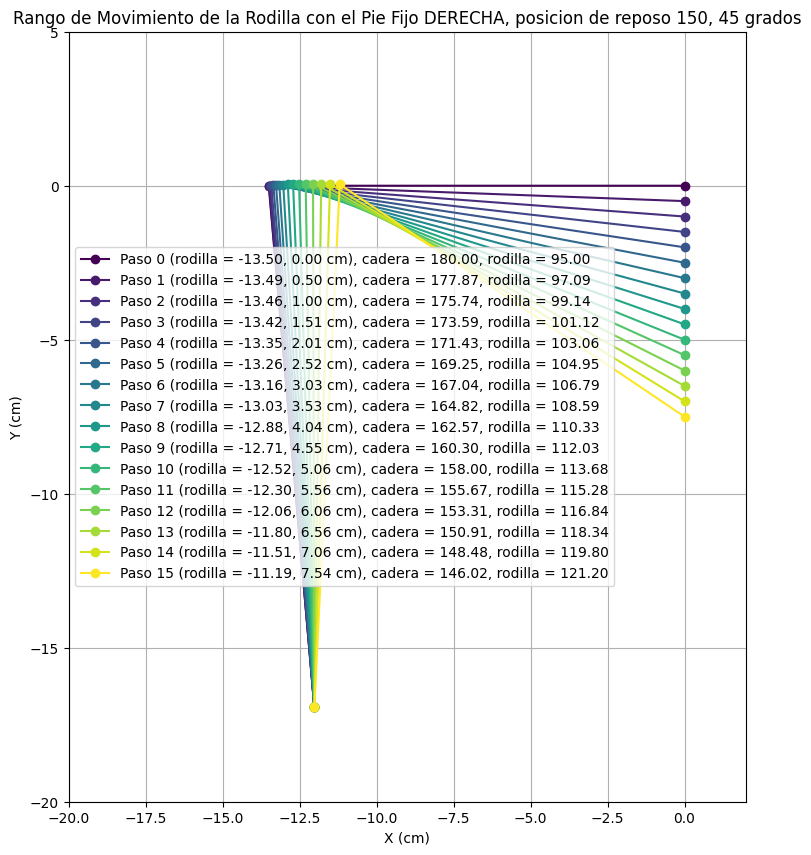

In [17]:
theta1_inicial = map_servo_to_angle(DERECHA_SUPERIOR, 45, calibrations)
theta2_inicial = map_servo_to_angle(DERECHA_INFERIOR, 50, calibrations)

print(theta1, theta2)


desplazamiento_vertical = -0.5  # bajar 1 cm
pasos = 15

_, (x_pie, y_pie) = cinemática_directa(theta1_inicial, theta2_inicial)

fig, ax = plt.subplots(figsize=(10, 10))

# Colores para los diferentes pasos
colors = plt.cm.viridis(np.linspace(0, 1, pasos+1))

# Lista para almacenar la posición de la rodilla en cada paso
posiciones_rodilla = []

# Visualizar el rango de movimiento de la rodilla para cada posición de la cadera
for i in range(pasos + 1):
    y_hip_new = i * desplazamiento_vertical

    # Calcular los nuevos ángulos para mantener la posición del pie constante
    theta1_new, theta2_new = cinemática_inversa(x_pie, y_pie, y_hip_new)
    theta2_new = np.abs(theta2_new)

    if theta1_new < 0:
        theta1_new += 360
    
    print(map_angle_to_servo(DERECHA_SUPERIOR, theta1_new, calibrations), map_angle_to_servo(DERECHA_INFERIOR, theta2_new, calibrations))
    
    (rodilla_x, rodilla_y), _ = cinemática_directa(theta1_new, theta2_new)

    # Visualizar la posición ajustada
    ax.plot([0, rodilla_x, x_pie], [y_hip_new, rodilla_y + y_hip_new, y_pie], 'o-', color=colors[i], label=f'Paso {i} (rodilla = {rodilla_x:.2f}, {rodilla_y:.2f} cm), cadera = {theta1_new:.2f}, rodilla = {theta2_new:.2f}')
    posiciones_rodilla.append((rodilla_x, rodilla_y))

# Configurar el gráfico
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title(f'Rango de Movimiento de la Rodilla con el Pie Fijo DERECHA, posicion de reposo 150, 45 grados')
ax.grid(True)
ax.set_xlim(-20, 2)
ax.set_ylim(-20, 5)
ax.set_aspect('equal', adjustable='box')


ax.legend()
plt.show()


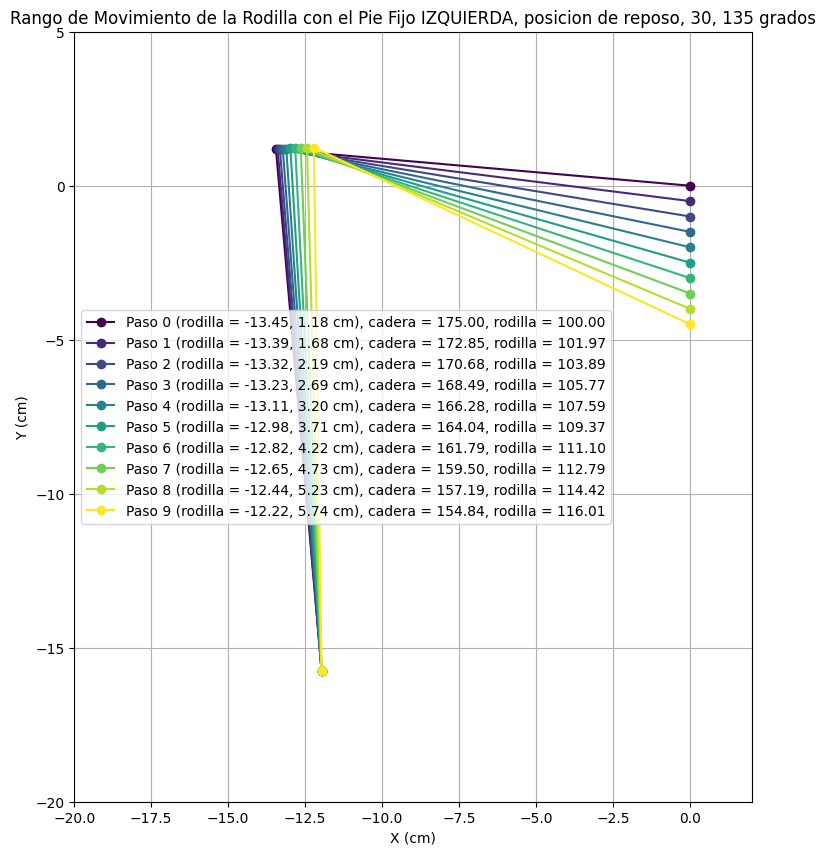

In [18]:
theta1_inicial = map_servo_to_angle(IZQUIERDA_SUPERIOR, 150, calibrations)
theta2_inicial = map_servo_to_angle(IZQUIERDA_INFERIOR, 135, calibrations)

desplazamiento_vertical = -0.5  # bajar 1 cm
pasos = 9

_, (x_pie, y_pie) = cinemática_directa(theta1_inicial, theta2_inicial)

fig, ax = plt.subplots(figsize=(10, 10))

# Colores para los diferentes pasos
colors = plt.cm.viridis(np.linspace(0, 1, pasos+1))

# Lista para almacenar la posición de la rodilla en cada paso
posiciones_rodilla = []

# Visualizar el rango de movimiento de la rodilla para cada posición de la cadera
for i in range(pasos + 1):
    y_hip_new = i * desplazamiento_vertical

    # Calcular los nuevos ángulos para mantener la posición del pie constante
    theta1_new, theta2_new = cinemática_inversa(x_pie, y_pie, y_hip_new)
    theta2_new = np.abs(theta2_new)

    if theta1_new < 0:
        theta1_new += 360

    (rodilla_x, rodilla_y), _ = cinemática_directa(theta1_new, theta2_new)

    # Visualizar la posición ajustada
    ax.plot([0, rodilla_x, x_pie], [y_hip_new, rodilla_y + y_hip_new, y_pie], 'o-', color=colors[i], label=f'Paso {i} (rodilla = {rodilla_x:.2f}, {rodilla_y:.2f} cm), cadera = {theta1_new:.2f}, rodilla = {theta2_new:.2f}')
    posiciones_rodilla.append((rodilla_x, rodilla_y))

# Configurar el gráfico
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title('Rango de Movimiento de la Rodilla con el Pie Fijo IZQUIERDA, posicion de reposo, 30, 135 grados')
ax.grid(True)
ax.set_xlim(-20, 2)
ax.set_ylim(-20, 5)
ax.set_aspect('equal', adjustable='box')


ax.legend()
plt.show()


### FUNCIÓN QUE BAJA EL CENTRO DE GRAVEDAD EN FUNCIÓN DE UN DESPLAZAMIENTO

In [19]:
def bajar_cadera(type, servo1, servo2, desplazamiento_vertical):
    """
    Baja la cadera a una nueva altura sin cambiar la posición del pie.
    """
    # Calcular los nuevos ángulos para mantener la posición del pie constante
    
    if type == "DERECHA": 
        theta1_inicial = map_servo_to_angle(DERECHA_SUPERIOR, servo1, calibrations)
        theta2_inicial = map_servo_to_angle(DERECHA_INFERIOR, servo2, calibrations)
    elif type == "IZQUIERDA":
        theta1_inicial = map_servo_to_angle(IZQUIERDA_SUPERIOR, servo1, calibrations)
        theta2_inicial = map_servo_to_angle(IZQUIERDA_INFERIOR, servo2, calibrations)
    else:
        return None
    
    _, (x_pie, y_pie) = cinemática_directa(theta1_inicial, theta2_inicial)
    
    theta1_new, theta2_new = cinemática_inversa(x_pie, y_pie, desplazamiento_vertical)
    theta2_new = np.abs(theta2_new)
    
    if (theta1_new < 0):
        theta1_new = theta1_new + 360
    
        (rodilla_x, rodilla_y), _ = cinemática_directa(theta1_new, theta2_new)
    return (rodilla_x, rodilla_y), (theta1_new, theta2_new)

### VISUALIZACIÓN DE TODO EL ROBOT Y EL RANGO DE MOVIMIENTO DE CADA EJE

135 315 145 325


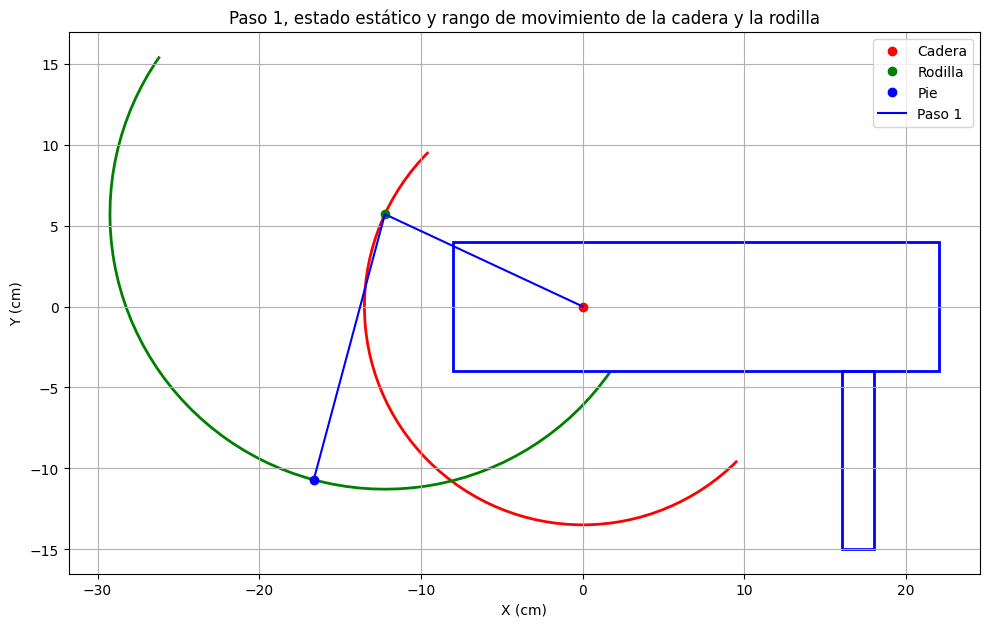

In [20]:
# Colores para los diferentes pasos
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Crear la figura y los ejes para los cinco subgráficos
fig, ax = plt.subplots(figsize=(10, 10))

servo1 = 20
servo2 = 45


angle_min_sup = map_servo_to_angle(DERECHA_SUPERIOR, 0, calibrations)
angle_max_sup = map_servo_to_angle(DERECHA_SUPERIOR, 180, calibrations)

angle_min_inf = map_servo_to_angle(DERECHA_INFERIOR, 0, calibrations)
angle_max_inf = map_servo_to_angle(DERECHA_INFERIOR, 180, calibrations)

print(angle_min_sup, angle_max_sup, angle_min_inf, angle_max_inf)

theta1 = map_servo_to_angle(DERECHA_SUPERIOR, servo1, calibrations)
theta2 = map_servo_to_angle(DERECHA_INFERIOR, servo2, calibrations)

(rodilla_x, rodilla_y) , (x_foot, y_foot) = cinemática_directa(theta1, theta2)
    # Visualizar la posición del pie en el subgráfico correspondiente

ax.plot(0, 0, 'ro', label='Cadera')
ax.plot(l1 * np.cos(np.radians(theta1)), l1 * np.sin(np.radians(theta1)), 'go', label='Rodilla')
ax.plot(x_foot, y_foot, 'bo', label='Pie')
ax.plot([0, l1 * np.cos(np.radians(theta1)), x_foot], [0, l1 * np.sin(np.radians(theta1)), y_foot], 
            color='blue', label=f'Paso 1')

arc = Arc((0, 0),l1 * 2, l1 * 2, angle=0, theta1=angle_min_sup, theta2=angle_max_sup, linewidth=2, color='red')
ax.add_patch(arc)

arc = Arc((rodilla_x, rodilla_y),l2 * 2, l2 * 2, angle=0, theta1=angle_min_inf, theta2=angle_max_inf, linewidth=2, color='green')
ax.add_patch(arc)

# Crear la caja
caja = Rectangle((-8, -4), 30, 8, edgecolor='blue', facecolor='none', linewidth=2)

pata_delantera = Rectangle((16, -15), 2, 11, edgecolor='blue', facecolor='none', linewidth=2)


# Añadir la caja a los ejes
ax.add_patch(caja)
ax.add_patch(pata_delantera)

    # Configurar el subgráfico
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title(f'Paso 1, estado estático y rango de movimiento de la cadera y la rodilla')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
ax.legend()

plt.tight_layout()
plt.show()


### ESTADO SIT

135 315 145 325


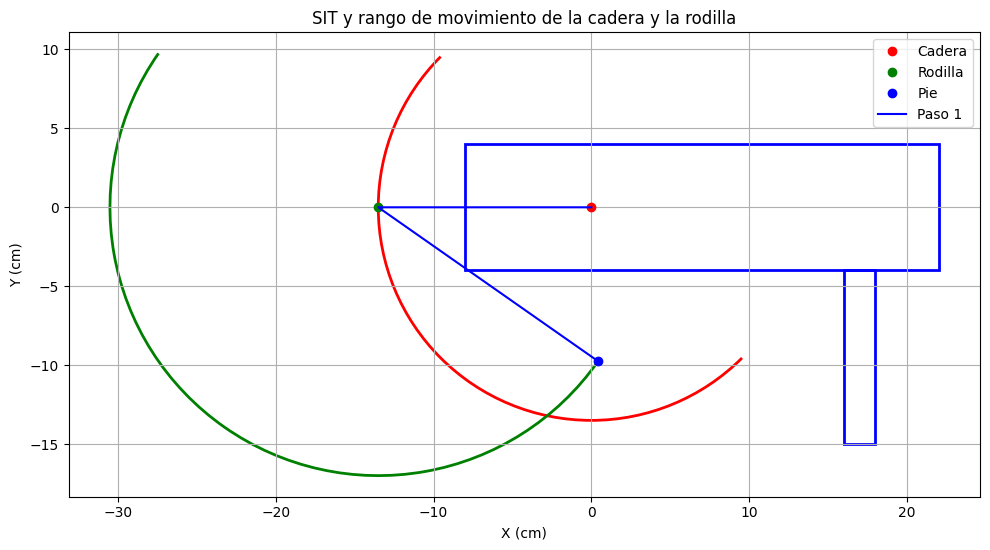

In [21]:
# Crear la figura y los ejes para los cinco subgráficos
fig, ax = plt.subplots(figsize=(10, 10))

servo1 = 45
servo2 = 0


angle_min_sup = map_servo_to_angle(DERECHA_SUPERIOR, 0, calibrations)
angle_max_sup = map_servo_to_angle(DERECHA_SUPERIOR, 180, calibrations)

angle_min_inf = map_servo_to_angle(DERECHA_INFERIOR, 0, calibrations)
angle_max_inf = map_servo_to_angle(DERECHA_INFERIOR, 180, calibrations)

print(angle_min_sup, angle_max_sup, angle_min_inf, angle_max_inf)

theta1 = map_servo_to_angle(DERECHA_SUPERIOR, servo1, calibrations)
theta2 = map_servo_to_angle(DERECHA_INFERIOR, servo2, calibrations)

(rodilla_x, rodilla_y) , (x_foot, y_foot) = cinemática_directa(theta1, theta2)
    # Visualizar la posición del pie en el subgráfico correspondiente

ax.plot(0, 0, 'ro', label='Cadera')
ax.plot(l1 * np.cos(np.radians(theta1)), l1 * np.sin(np.radians(theta1)), 'go', label='Rodilla')
ax.plot(x_foot, y_foot, 'bo', label='Pie')
ax.plot([0, l1 * np.cos(np.radians(theta1)), x_foot], [0, l1 * np.sin(np.radians(theta1)), y_foot], 
            color='blue', label=f'Paso 1')

arc = Arc((0, 0),l1 * 2, l1 * 2, angle=0, theta1=angle_min_sup, theta2=angle_max_sup, linewidth=2, color='red')
ax.add_patch(arc)

arc = Arc((rodilla_x, rodilla_y),l2 * 2, l2 * 2, angle=0, theta1=angle_min_inf, theta2=angle_max_inf, linewidth=2, color='green')
ax.add_patch(arc)

# Crear la caja
caja = Rectangle((-8, -4), 30, 8, edgecolor='blue', facecolor='none', linewidth=2)

pata_delantera = Rectangle((16, -15), 2, 11, edgecolor='blue', facecolor='none', linewidth=2)


# Añadir la caja a los ejes
ax.add_patch(caja)
ax.add_patch(pata_delantera)
    # Configurar el subgráfico
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title(f'SIT y rango de movimiento de la cadera y la rodilla')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
ax.legend()

plt.tight_layout()
plt.show()


### ESTADO STANDUP

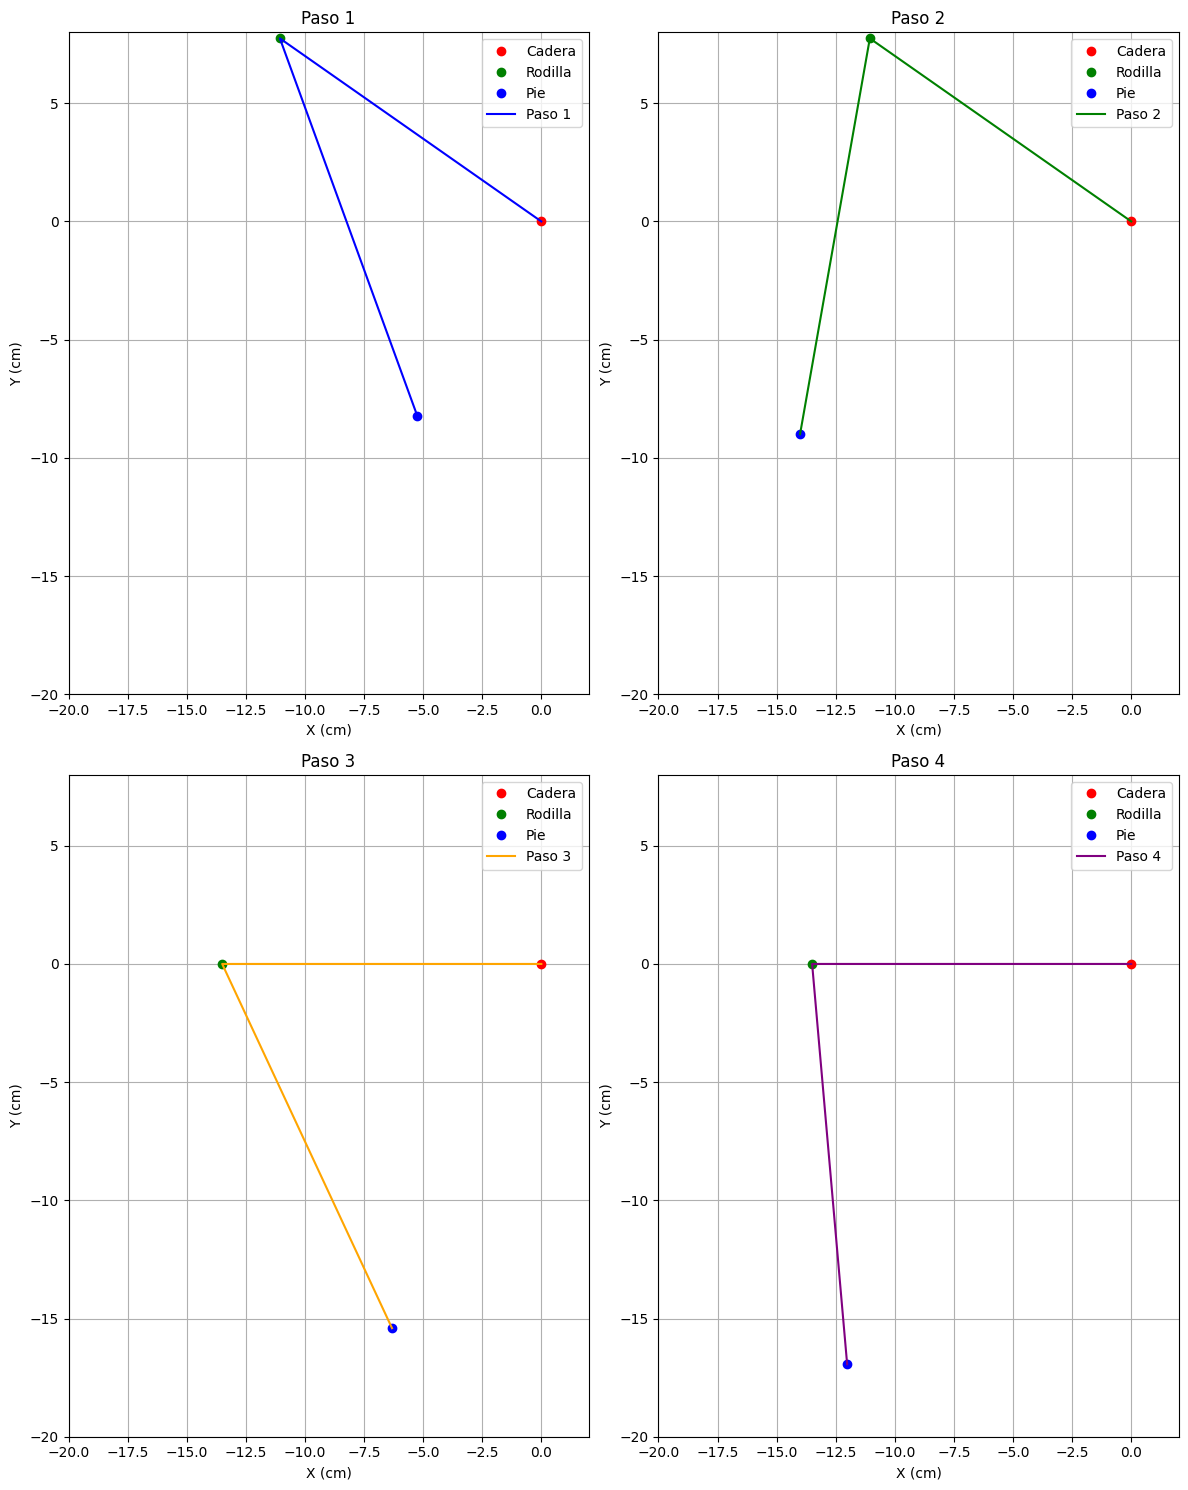

In [24]:

# Longitudes de los eslabones
l1 = 13.5  # longitud de la cadera a la rodilla (cm)
l2 = 17  # longitud de la rodilla al pie (cm)

# Ángulos de las articulaciones (en grados) para los cinco pasos
thetas =  [
    (145, 145),  # Paso 1
    (145, 115),   # Paso 2
    (180, 115),   # Paso 3
    (180, 95),   # Paso 5 (volver al paso inicial)
]

# Colores para los diferentes pasos
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Crear la figura y los ejes para los cinco subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 15))
axs = axs.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

# Iterar sobre cada paso y visualizar la posición del pie en cada paso
for i, (theta1, theta2) in enumerate(thetas, start=1):
    # Calcular las coordenadas del pie (posición final)
    x_foot = l1 * np.cos(np.radians(theta1)) + l2 * np.cos(np.radians(theta1 + theta2))
    y_foot = l1 * np.sin(np.radians(theta1)) + l2 * np.sin(np.radians(theta1 + theta2))
    
    # Visualizar la posición del pie en el subgráfico correspondiente
    ax = axs[i-1]
    ax.plot(0, 0, 'ro', label='Cadera')
    ax.plot(l1 * np.cos(np.radians(theta1)), l1 * np.sin(np.radians(theta1)), 'go', label='Rodilla')
    ax.plot(x_foot, y_foot, 'bo', label='Pie')
    ax.plot([0, l1 * np.cos(np.radians(theta1)), x_foot], [0, l1 * np.sin(np.radians(theta1)), y_foot], 
            color=colors[i-1], label=f'Paso {i}')

    # Configurar el subgráfico
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_title(f'Paso {i}')
    ax.grid(True)
    ax.set_xlim(-20, 2)
    ax.set_ylim(-20, 8)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()

# Añadir un espacio vacío para el último subgráfico que no se usa

plt.tight_layout()
plt.show()
